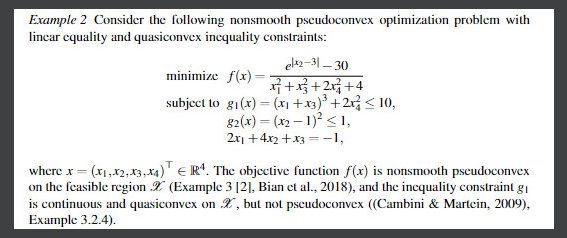

In [11]:
from IPython import display
display.Image("/Users/tuantran/Documents/tuan/Optimization/img1.png")

In [8]:
import numpy as np
from autograd import grad
import autograd.numpy as np1
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random
import time
from scipy.optimize import BFGS,SR1
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint

# GDA

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


GDA:  1.0821120738983154
GDA:  1.1277987957000732
GDA:  1.015535831451416


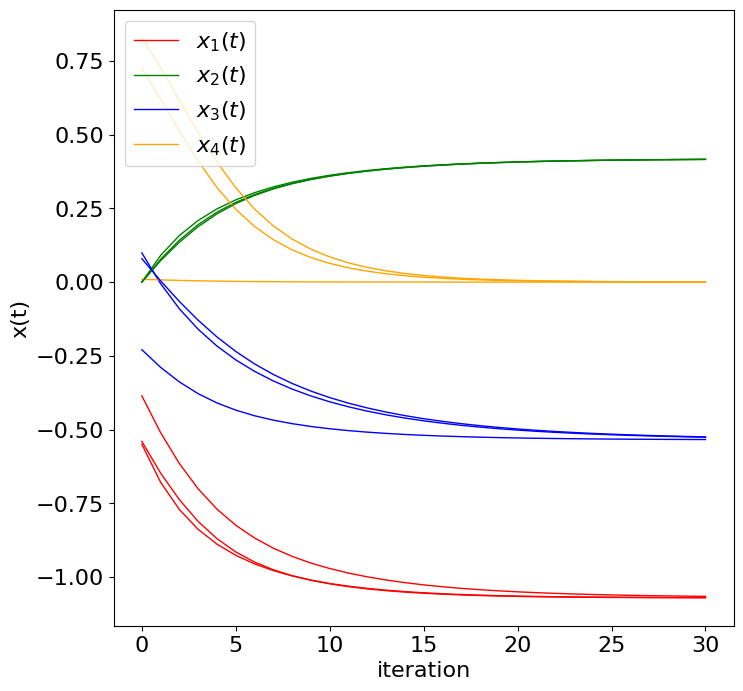

In [9]:
# RK4 method
def ode_solve_G(z0, G,epsi_t,mut,n):
    """
    Simplest RK4 ODE initial value solver
    """
    n_steps = 500
    z = z0
    h = np.array([0.01])
    for i_step in range(n_steps):
        k1 = h*G(z,epsi_t,mut,n)
        k2 = h * (G((z+h/2),epsi_t,mut,n))
        k3 = h * (G((z+h/2),epsi_t,mut,n))
        k4 = h * (G((z+h),epsi_t,mut,n))
        k = (1/6)*(k1+2*k2+2*k3+k4)
        z = z + k
    return z
def theta(x,mu):
    if np1.abs(x) >= (mu/2):
        return np1.abs(x)
    else:
        return x**2/mu + mu/4 
def f_mu(x,mu):
    return (np1.exp(theta(x[1]-3,mu)) - 30) / (x[0]**2 + x[2]**2 + 2*(x[3]**2) + 4)
def f(x):
    return (np1.exp(np1.abs(x[1]-3)) - 30) / (x[0]**2 + x[2]**2 + 2*(x[3]**2) + 4)
def g1(x):
    return ((x[0] + x[2])**3 + 2*(x[3])**2) - 10
def g2(x):
    return ((x[1] - 1)**2) - 1
def g3(x):
    x = np.array(x)
    A = np.array([[2,4,1,0]])
    b = np.array([[-1]])
    return (A@(x.T) - b.T).tolist()[0][0] # 
g1_dx = grad(g1)
g2_dx = grad(g2)
g3_dx = grad(g3)
g_dx = [g1_dx,g2_dx]
f_dx = grad(f)
f_dx_mu = grad(f_mu)
cons = ({'type': 'eq',
          'fun' : lambda x: np.array([g3(x)]),
          'jac' : lambda x: np.array([2,4,1,0])},
        {'type': 'ineq',
          'fun' : lambda x: np.array([-g1(x)]),
          'jac' : lambda x: np.array([-g1_dx(x)])},
         {'type': 'ineq',
          'fun' : lambda x: np.array([-g2(x)]),
          'jac' : lambda x: np.array([-g2_dx(x)])})
def rosen(x,y):
    """The Rosenbrock function"""
    return np.sqrt(np.sum((x-y)**2))
def find_min(y,n):
    x = np.random.rand(1,n).tolist()[0]
    res = minimize(rosen, x, args=(y), jac="2-point",hess=BFGS(),
                constraints=cons,method='trust-constr', options={'disp': False})
    return res.x
def run_nonsmooth1(x, max_iters, f, f_dx,n,alpha,mu0):
    res = []
    val = []
    lda = 0.1 #1e9
    sigma = 0.1 #100
    mut = mu0
    K = np.random.rand(1,1)
    res.append(x)
    val.append(f_mu(x,mut))
    x_pre = x
    for t in range(max_iters):
        y = x - lda*f_dx_mu(x,mut)
        x_pre = x.copy()
        x = find_min(y,n)
        if f_mu(x,mut) - f_mu(x_pre,mut) + sigma*(np.dot(f_dx_mu(x_pre,mut).T,x_pre - x)) <= 0:
            lda = lda
        else:
            lda = K*lda
        mut = mut*np.exp(-alpha*t)
        res.append(x)
        val.append(f_mu(x,mut))

    return res,val
def plot_x(sol_all,count,max_iters):
    t = [i for i in range(max_iters+1)]
    plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 16})
    for i in range(count):
        plt.plot(t, sol_all[i][:,0],color='red',label=r'$x_{1}(t)$',linewidth=1)
        plt.plot(t, sol_all[i][:,1],color='green',label=r'$x_{2}(t)$',linewidth=1)
        plt.plot(t, sol_all[i][:,2],color='blue',label=r'$x_{3}(t)$',linewidth=1)
        plt.plot(t, sol_all[i][:,3],color='orange',label=r'$x_{4}(t)$',linewidth=1)
    plt.xlabel('iteration')
    plt.ylabel('x(t)')
    plt.legend([r'$x_{1}(t)$',r'$x_{2}(t)$',r'$x_{3}(t)$',r'$x_{4}(t)$']) #,r'$x_{4}(t)$',r'$x_{5}(t)$',r'$x_{6}(t)$',r'$x_{7}(t)$',r'$x_{8}(t)$',r'$x_{9}(t)$',r'$x_{10}(t)$'])
    plt.show()
if __name__ == '__main__':
    num = 3 # number of init points
    max_iters = 30 # number of interations
    max_iters1 = 30
    sol_all,sol_all1 = [],[]
    val_all,val_all1 = [],[]
    count = 0
    epsilon = 0.1
    mu0 = np.random.rand(1) # init mu0 
    epsi0 = np.random.rand(1) # init epsi0
    alpha = np.random.rand(1) # init alpha
    n = 4 # dimension x
    x_init = np.random.rand(1,n)
    for i in range(num):
        x0 = np.random.rand(1,n)
        x0 = find_min(x0,n) # init point
        count += 1

        t2 = time.time()
        res1,val1 = run_nonsmooth1(x0, max_iters1, f, f_dx,n,alpha,mu0)
        e2 = time.time()
        print("GDA: ",e2-t2)
        tmp1 = np.array(res1)[:,:]
        sol_all1.append(tmp1)

    # Plot trajectory
    plot_x(sol_all1,count,max_iters)

